In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Обучать модели можно по отдельным elo, по разнице и среднему

In [2]:
elos = pd.read_csv(r'C:\Users\Asus\PredictingRaitings\data\elos.csv')
elos['MeanElos']=elos.mean(axis=1).astype(int)
elos['DiffElos']=abs(elos.WhiteElo-elos.BlackElo).astype(int)
# сумма рейтингов задает общее качество партии
elos['SumElos']=abs(elos.WhiteElo+elos.BlackElo).astype(int)
print(elos.describe())
elos.head()

           WhiteElo      BlackElo      MeanElos      DiffElos       SumElos
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000
mean    2246.851040   2033.380040   2139.865720    378.131080   4280.231080
std      268.384897    667.715458    387.718946    580.537775    775.440211
min     1021.000000      2.000000    727.000000      0.000000   1455.000000
25%     2075.000000   1974.000000   2008.000000     97.000000   4017.000000
50%     2272.000000   2226.000000   2229.000000    184.000000   4458.000000
75%     2447.000000   2426.000000   2403.000000    309.000000   4806.000000
max     2864.000000   2881.000000   2840.000000   2722.000000   5681.000000


,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
0,2354,2411,2382,57,4765
1,2523,246,1384,2277,2769
2,1915,1999,1957,84,3914
3,2446,2191,2318,255,4637
4,2168,2075,2121,93,4243


In [3]:
elos_reject=elos[(elos['BlackElo']<1200)|(elos['WhiteElo']<1200)]
elos_reject.head()

,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
1,2523,246,1384,2277,2769
9,2611,252,1431,2359,2863
13,2357,211,1284,2146,2568
21,2345,256,1300,2089,2601
42,2450,217,1333,2233,2667


In [4]:
elos = elos[~elos.index.isin(elos_reject.index)]
elos.shape

(22434, 5)

In [5]:
games= pd.read_csv(r'C:\Users\Asus\PredictingRaitings\data\games.csv')
games.Moves=games.Moves.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Scores=games.Scores.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Scores=games.Scores.apply(lambda x: list(map(int,x.split())))
games.Moves=games.Moves.apply(lambda x: x.split())
games.head()

,Result,Moves,Scores,NumMoves
0,1/2-1/2,"['Nf3', 'Nf6', 'c4', 'c5', 'b3', 'g6', 'Bb2', ...","[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",19
1,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Nxe5...","[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",7
2,0-1,"['e4', 'd5', 'exd5', 'Nf6', 'd4', 'Nxd5', 'Nf3...","[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",53
3,1-0,"['c4', 'Nf6', 'Nc3', 'd6', 'd4', 'e5', 'Nf3', ...","[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",39
4,1-0,"['e4', 'c5', 'Nf3', 'd6', 'b4', 'Nf6', 'bxc5',...","[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",25


#### Данные без рейтинга (submissions к соревнованию) не помогут для реализации модели

In [6]:
games = games[games.index.isin(elos.index)]
games.shape

(22434, 4)

In [7]:
games_small=games[games['NumMoves']<10]
games_small

,Result,Moves,Scores,NumMoves
251,1/2-1/2,"['d4', 'Nf6', 'Nf3', 'e6', 'g3', 'b5', 'Bg2', ...","[19, 17, 8, 21, -5, 42, 22, 14, 18, 43, 29, 36...",8
308,1-0,"['d4', 'd5', 'Bf4', 'Nf6']","[19, 13, 16, 16]",2
762,1/2-1/2,"['d4', 'd5', 'Nf3', 'Nf6', 'e3', 'e6', 'Bd3', ...","[19, 13, 10, 22, 15, 8, 13, 13, 5, 2, 10, 16, ...",7
828,1/2-1/2,"['e4', 'e5', 'Nf3']","[13, 44, 26]",2
929,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Nf3'...","[26, 48, 46, 29, 23, 7, 23, 24, 14, 25, 27, 51...",8
943,1/2-1/2,"['c4', 'c5', 'Nc3', 'Nc6', 'Nf3', 'Nf6', 'g3',...","[2, 26, 12, 7, 23, 22, -3, 14, 22, 29, 28, 29, 7]",7
984,1/2-1/2,"['c4', 'Nf6', 'Nc3', 'c5', 'Nf3', 'd5', 'cxd5'...","[2, 21, 11, 18, 22, 72, 53, 53, 31]",5
1307,1-0,"['c4', 'Nf6', 'g3', 'e6']","[2, 15, -29, -10]",2
1319,1/2-1/2,"['d4', 'd5', 'c4', 'dxc4', 'Nf3', 'Nf6', 'e3',...","[19, 13, 15, 53, 56, 58, 63, 55, 62, 61, 53, 6...",9
1540,1-0,['e4'],[],1


In [8]:
games = games[~games.index.isin(games_small.index)]
games.shape

(22230, 4)

In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22230 entries, 0 to 24999
Data columns (total 4 columns):
Result      22230 non-null object
Moves       22230 non-null object
Scores      22230 non-null object
NumMoves    22230 non-null int64
dtypes: int64(1), object(3)
memory usage: 868.4+ KB


#### Добавление некоторых признаков для удаления выбросов

In [10]:
games['MeanScore']=games.Scores.apply(lambda x: np.mean(x))
games['ModeScore']=games.Scores.apply(lambda x: max(set(x), key=x.count))
games['FinalScore']=games.Scores.apply(lambda x: x[-1])
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22230 entries, 0 to 24999
Data columns (total 7 columns):
Result        22230 non-null object
Moves         22230 non-null object
Scores        22230 non-null object
NumMoves      22230 non-null int64
MeanScore     22230 non-null float64
ModeScore     22230 non-null int64
FinalScore    22230 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.4+ MB


In [11]:
games_draws=games[games['Result']=='1/2-1/2']
games_draws.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,6805.000000,6805.000000,6805.000000,6805.000000
mean,41.189860,15.269665,6.170610,7.703600
std,19.832095,56.830603,56.528609,258.570554
min,10.000000,-1854.552381,-3980.000000,-5231.000000
25%,27.000000,-4.368421,0.000000,0.000000
50%,40.000000,15.761905,0.000000,0.000000
75%,53.000000,35.480769,9.000000,12.000000
max,165.000000,1000.052083,393.000000,10289.000000


Удаляем ничейные партии, где оценка конечной позиции слишком высокая

In [12]:
games_draws_reject=games_draws[(abs(games_draws['FinalScore'])>1000)]
games_draws_reject.head()

,Result,Moves,Scores,NumMoves,MeanScore,ModeScore,FinalScore
67,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Bd3'...","[26, 48, 46, 29, 23, 7, 16, 22, 1, 14, -12, -2...",53,116.698113,0,10289
1400,1/2-1/2,"['d4', 'd5', 'c4', 'c6', 'Nf3', 'Nf6', 'Nc3', ...","[19, 13, 9, 34, 45, 40, 41, 37, 20, 41, 43, 46...",69,8.014599,0,-4926
2223,1/2-1/2,"['d4', 'd6', 'c4', 'e5', 'Nf3', 'e4', 'Ng5', '...","[19, 42, 38, 27, 39, 17, -12, -16, 18, -10, 29...",63,73.150794,0,5403
2459,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'd3',...","[26, 44, 25, 14, 19, 15, 12, 19, 0, 0, -3, 37,...",41,-73.024691,0,-1266
3666,1/2-1/2,"['d4', 'Nf6', 'Bf4', 'e6', 'e3', 'd5', 'Nf3', ...","[19, 17, 17, 23, 23, 22, 23, 22, 13, 8, -1, -1...",44,30.113636,23,4526


In [13]:
games = games[~games.index.isin(games_draws_reject.index)]
games.shape

(22209, 7)

Удаляем результативные партии, где меньше 20 ходов и низкая оценка финальной позиции (вероятно нарушение правил или другое обстоятельство, не влияющее на качество игры)

In [14]:
games_reject=games[(games['NumMoves']<20)
                         &((games['Result']=='1-0')| (games['Result']=='0-1'))
                         &(abs(games['FinalScore'])<50)]
games_reject.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,28.000000,28.000000,28.000000,28.000000
mean,14.750000,23.297588,13.178571,7.000000
std,3.192874,26.406560,21.764826,18.909139
min,10.000000,-34.454545,-46.000000,-28.000000
25%,12.000000,13.285183,0.750000,-3.750000
50%,15.000000,19.542857,8.500000,2.000000
75%,18.000000,30.622917,21.500000,17.750000
max,19.000000,122.970588,84.000000,49.000000


In [15]:
games = games[~games.index.isin(games_reject.index)]
games.shape

(22181, 7)

Удаляем ничейные партии с количеством ходов меньше 15 (скорее всего договорные)

In [16]:
games_draws_moves_reject=games_draws[games_draws['NumMoves']<15]
games_draws_moves_reject.shape

(389, 7)

In [17]:
games = games[~games.index.isin(games_draws_moves_reject.index)]
games.shape

(21792, 7)

In [18]:
games.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,21792.000000,21792.000000,21792.000000,21792.000000
mean,42.298504,30.738080,12.692961,111.923366
std,16.220823,233.522695,438.944715,2307.046020
min,10.000000,-2162.262500,-10894.000000,-12261.000000
25%,31.000000,-60.964881,0.000000,-364.000000
50%,40.000000,24.585859,0.000000,0.000000
75%,51.000000,123.916258,26.000000,547.000000
max,165.000000,2073.289256,11259.000000,12337.000000


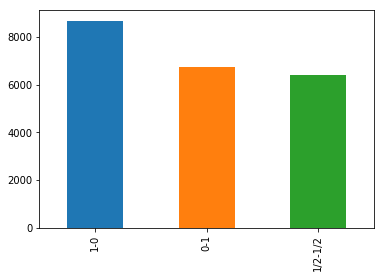

In [19]:
games['Result'].value_counts().plot('bar')

In [20]:
elos = elos[elos.index.isin(games.index)]
elos.shape

(21792, 5)

Белые в данном наборе выигрывали чаще

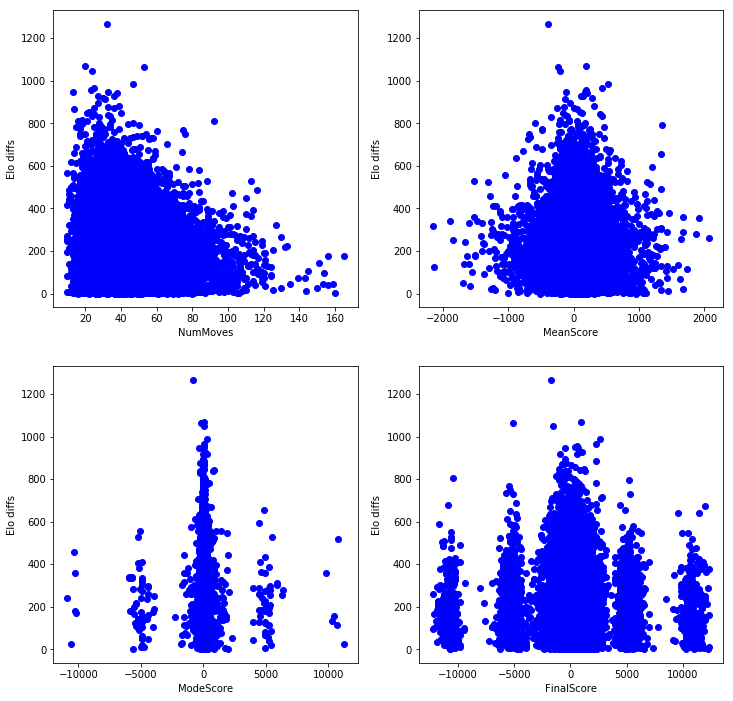

In [21]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+3], elos.DiffElos, color = 'b')
    xl=games.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Elo diffs")
    plot_number += 1

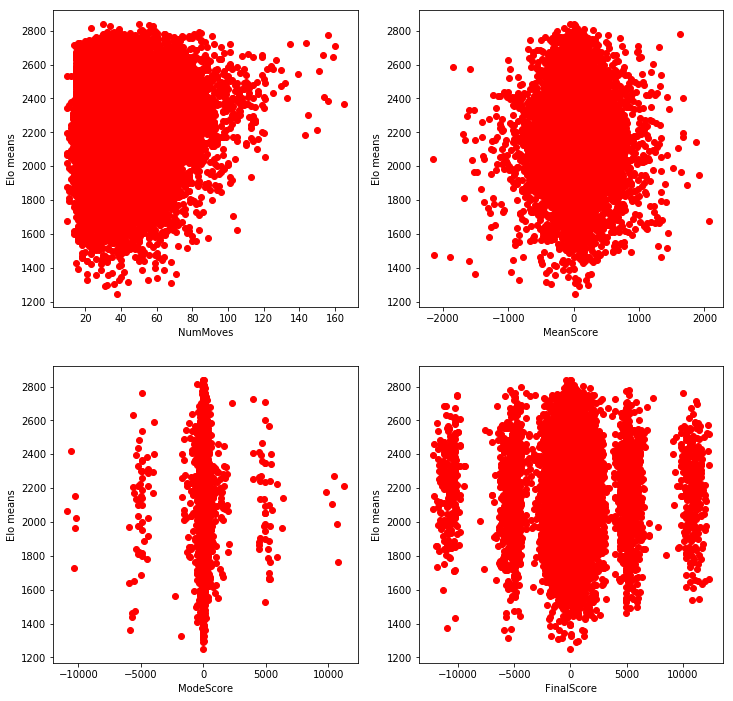

In [22]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+3], elos.MeanElos, color = 'r')
    xl=games.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Elo means")
    plot_number += 1

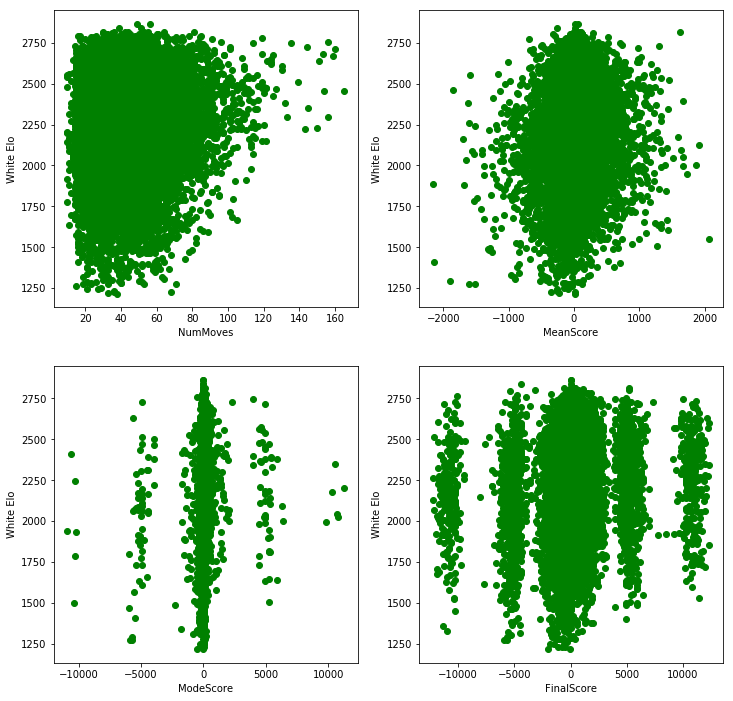

In [23]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+3], elos.WhiteElo, color = 'g')
    xl=games.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("White Elo")
    plot_number += 1

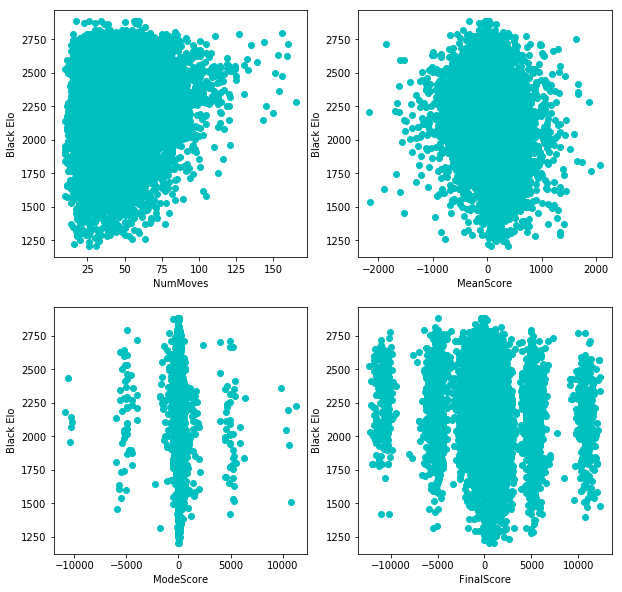

In [25]:
# Благодаря построению этих графиков, было найдено, что есть выбросы по рейтингу черных
fig=plt.figure(figsize=(10,10))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+3], elos.BlackElo, color = 'c')
    xl=games.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Black Elo")
    plot_number += 1

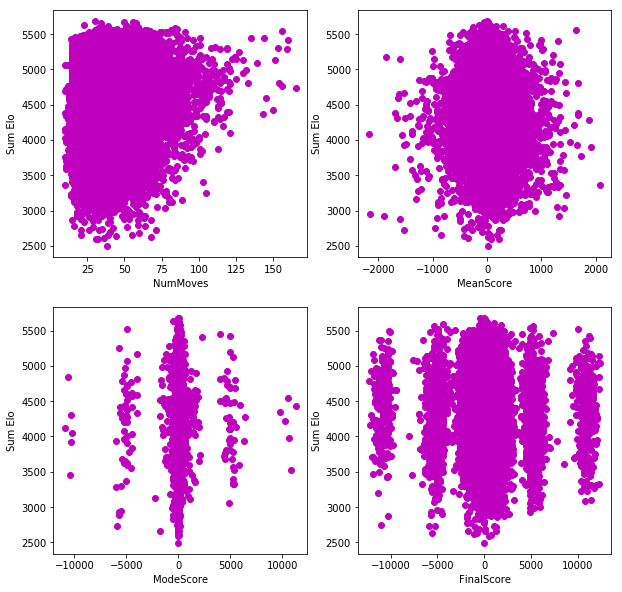

In [26]:
fig=plt.figure(figsize=(10,10))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+3], elos.SumElos, color = 'm')
    xl=games.columns[plot_number+3]
    plt.xlabel (xl)
    plt.ylabel ("Sum Elo")
    plot_number += 1

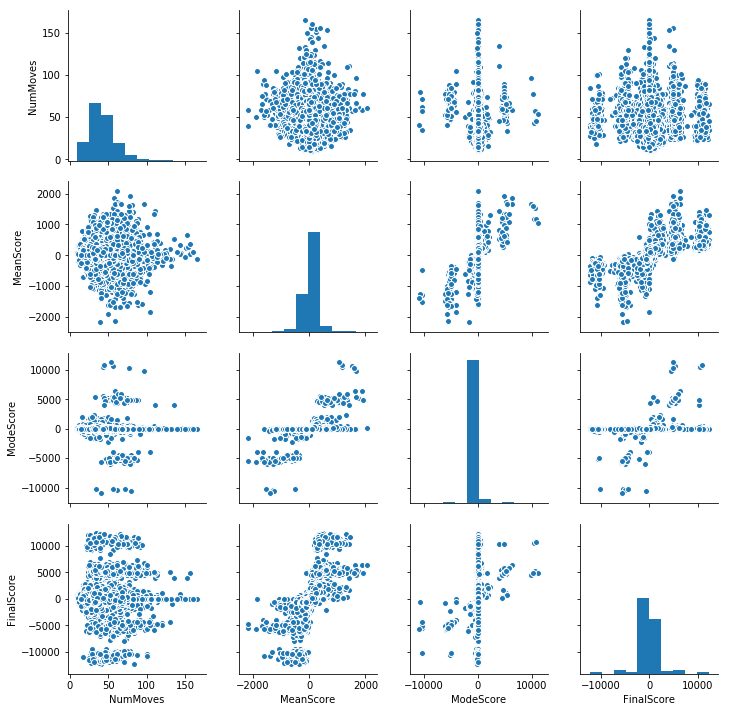

In [27]:
sns.pairplot(games)

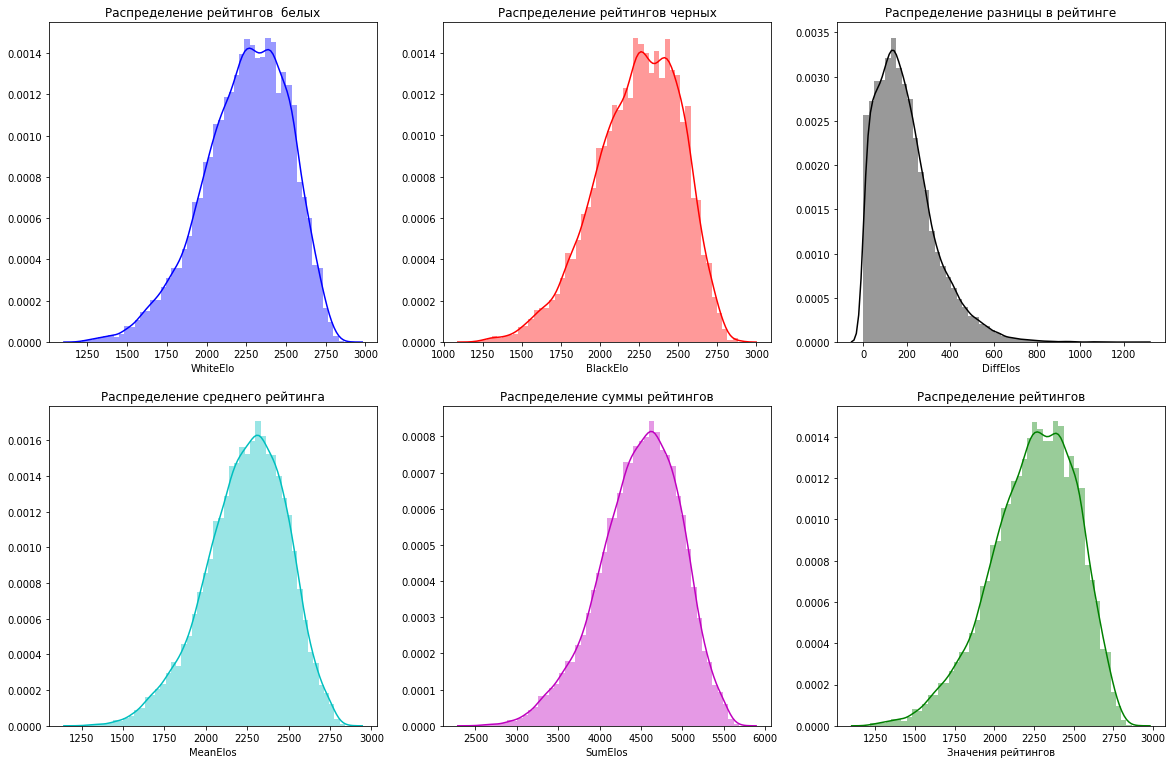

In [31]:
fig=plt.figure(figsize=(20,20))

ax1=plt.subplot(3,3,1)
sns.distplot(elos.WhiteElo,color='b')
ax1.set_title('Распределение рейтингов  белых')

ax2=plt.subplot(3,3,2)
sns.distplot(elos.BlackElo,color='r')
ax2.set_title('Распределение рейтингов черных')

ax3=plt.subplot(3,3,3)
sns.distplot(elos.DiffElos,color='k')
ax3.set_title('Распределение разницы в рейтинге')

ax4=plt.subplot(3,3,4)
sns.distplot(elos.MeanElos,color='c')
ax4.set_title('Распределение среднего рейтинга')

ax5=plt.subplot(3,3,5)
sns.distplot(elos.SumElos,color='m')
ax5.set_title('Распределение суммы рейтингов')

allElos=elos.WhiteElo
allElos.append(elos.BlackElo)
ax6=plt.subplot(3,3,6)
sns.distplot(allElos,color='g')
ax6.set_title('Распределение рейтингов')
ax6.set_xlabel("Значения рейтингов")
plt.show()

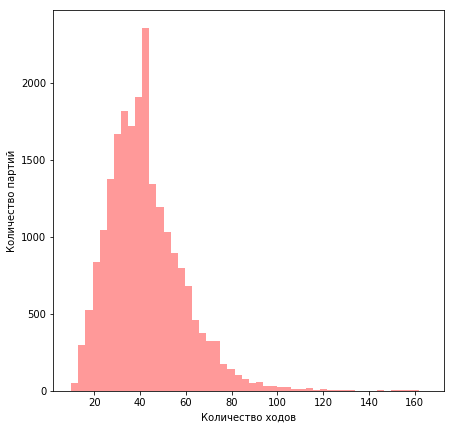

In [32]:
fig=plt.figure(figsize=(7,7))
sns.distplot(games.NumMoves,color='r',kde=False)
plt.ylabel('Количество партий')
plt.xlabel('Количество ходов')
plt.show()

In [33]:
games.to_csv(r'C:\Users\Asus\PredictingRaitings\data\clean_games.csv', sep=',',index=False)
elos.to_csv(r'C:\Users\Asus\PredictingRaitings\data\clean_elos.csv', sep=',',index=False)